In [1]:
import tensorflow as tf # Models ran in venv python 3.9.16 with GPU computing support
from tensorflow.keras.utils import plot_model
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import ast
import ecg_plot
import xgboost as xgb 
import tensorflow as tf # Models ran in venv python 3.9.16 with GPU computing support
import os
import scipy.io as sio

In [2]:
sr = 100
quick_load = True

In [3]:
with tf.device('/CPU:0'):
    ### Loading raw data into mutable Datframes
    def load_data():
        ptb = pd.read_csv('../../data/ptbxl_database.csv')
        def load_raw_data(df, sampling_rate, path):
            if(sampling_rate == 100):
                data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
            else:
                data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
            data = np.array([signal for signal, meta in data])
            return data
        
        # load and convert annotation data
        Y = pd.read_csv('../../data/ptbxl_database.csv', index_col='ecg_id')
        Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

        # Load raw signal data
        X = load_raw_data(Y, sr, '../../data/')

        # Load scp_statements.csv for diagnostic aggregation
        agg_df = pd.read_csv('../../data/scp_statements.csv', index_col=0)
        agg_df = agg_df[agg_df.diagnostic == 1]

        def aggregate_diagnostic(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in agg_df.index:
                    tmp.append(agg_df.loc[key].diagnostic_class)
            return list(set(tmp))


        # Apply diagnostic superclass
        Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)


if(quick_load):
    X = np.load('../../data/X_raw.npy')
    Y = pd.read_csv('../../data/Y_raw.csv')
else:
    X,Y = load_data()

In [4]:
Y.sex.to_numpy()

array([1, 0, 1, ..., 1, 1, 0], dtype=int64)

### Loading Fake ECGS

In [5]:
gen_18_25 = np.load("../../data/fake_ecgs/10000_[18-25]_generated_ecg_signals.npy")
gen_25_49 = np.load("../../data/fake_ecgs/10000_[25-49]_generated_ecg_signals.npy")
gen_50_74 = np.load("../../data/fake_ecgs/10000_[50-75]_generated_ecg_signals.npy")
gen_75_88 = np.load("../../data/fake_ecgs/10000_[75-88]_generated_ecg_signals.npy")

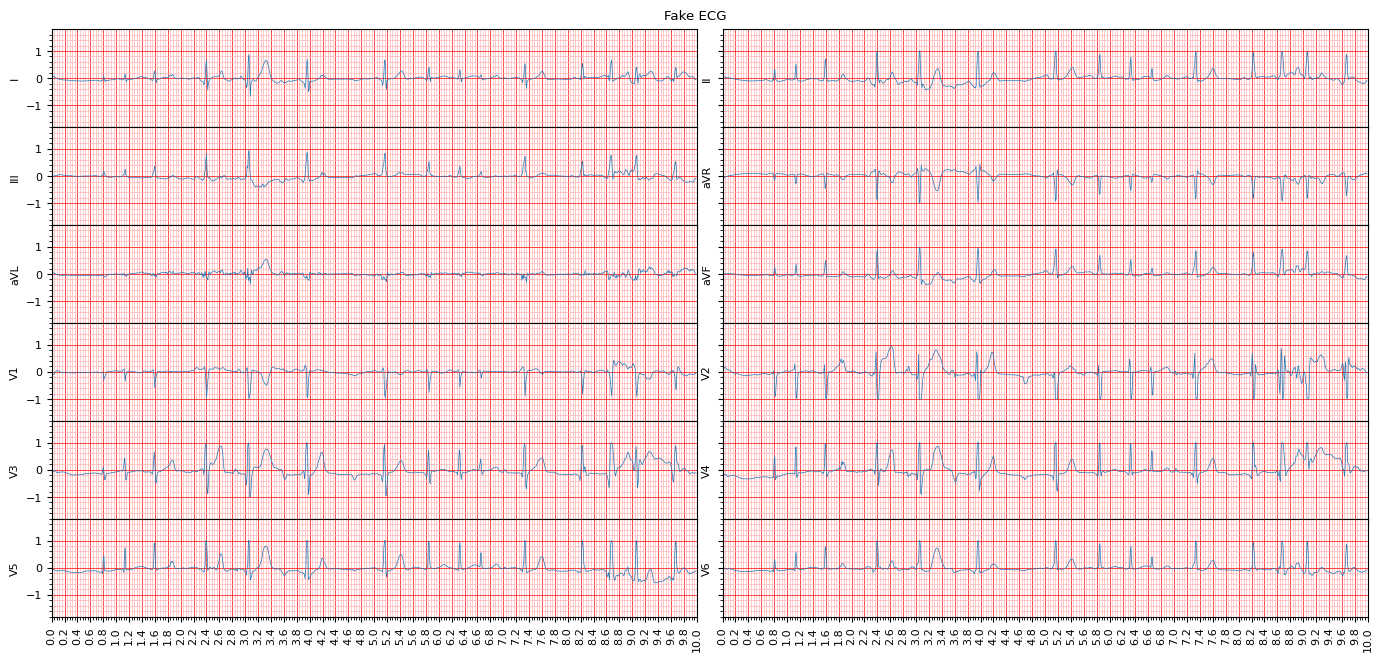

In [6]:
ecg_plot.plot_12(tf.transpose(gen_18_25, (0,2,1))[46, :, :], sample_rate=sr, title = "Fake ECG")

In [7]:

import numpy as np
from scipy import signal

def normalize(X, shape = False):
    # Compute mean and standard deviation along axis 1 and 2
    X_mean = np.mean(X)
    X_std = np.std(X)

    if(shape):
        print(X.shape)
    # Normalize data by subtracting mean and dividing by standard deviation
    return ((X - X_mean) / X_std)

#____________________________________________________________________________________#

bld = 0.5
def baseline_drift(X, baseline, range = 0):
    bld_range = (baseline-range, baseline+range)
    random_shifts = np.random.uniform(bld_range[0], bld_range[1], size = X.shape)
    return X + random_shifts

#____________________________________________________________________________________#

# Define the filter parameters
fs = 100  # Sampling frequency (Hz)
lowcut = 0.5  # Lower cutoff frequency (Hz)
highcut = 40.0  # Higher cutoff frequency (Hz)
filter_order = 4  # Filter order

def bandpass(X, fs, lowcut, highcut, filter_order):
    # Apply bandpass filter to each channel
    filtered_data = np.zeros_like(X)
    for i in range(X.shape[2]):
        for j in range(X.shape[0]):
            b, a = signal.butter(filter_order, [lowcut, highcut], fs=fs, btype='band', output='ba')
            filtered_data[j, :, i] = signal.filtfilt(b, a, X[j, :, i])

    # Print the shape of the filtered data
    return filtered_data

#____________________________________________________________________________________#

def da_apply(X, functions, shape = False):
    X_final = X.copy()

    # Applys DA Augments in specified order
    for func_dict in functions:
        func = func_dict['func']
        if(func_dict['params'] == None):
            X_final = func(X_final)     
        else:
            params = func_dict['params']
            X_final = func(X_final, *params)  

    if(shape == True):
        print(X_final.shape)

    return X_final

#func_dict = [{'func': normalize, 'params': [None]}]

#func_dict = [{'func': baseline_drift, 'params': [0,0.05]}]

# func_dict =[{'func': normalize, 'params': [None]},
#             {'func': bandpass, 'params': [100, 0.5, 10, 3]}, # 100, 0.5, 10, 3
#             {'func': baseline_drift, 'params': [0,0.075]}]

In [8]:

with tf.device('/GPU:0'):
    func_dict =[{'func': normalize, 'params': [None]},  # Normalizing across the entire data set instead of by lead
                {'func': baseline_drift, 'params': [0,0.075]}]  # I found that simulating a 0.075 drift works best
    
    X_final = da_apply(X, func_dict) # If you want to experiment with data shape more, use a smaller data size. Subset X

    gen_18_25_final = da_apply(gen_18_25, func_dict)
    gen_25_49_final = da_apply(gen_25_49, func_dict)
    gen_50_74_final = da_apply(gen_50_74, func_dict)
    gen_75_88_final = da_apply(gen_75_88, func_dict)

In [9]:
true_age_block_labels_list = []
true_sex_labels_list = []

def data_subsetting(X, Y, lower, higher):

        Y_filtered = Y.age.to_numpy()

        X_filtered = X[(Y_filtered < higher) & (Y_filtered >= lower)] # Additional filtering of patients older than 89 and younger than 18
        Y_filtered = Y_filtered[(Y_filtered < higher) & (Y_filtered >= lower)]
        Y_filtered_full = Y[(Y.age < higher) & (Y.age >= lower)]

        return Y_filtered


def data_label_subsetting(X, Y, lower, higher):

        Y_filtered_age = Y.age.to_numpy()
        Y_filtered_sex = Y.sex.to_numpy()
        Y_filtered_age = Y_filtered_age[(Y_filtered_age < higher) & (Y_filtered_age >= lower)]
        Y_filtered_sex = Y_filtered_sex[(Y.age.to_numpy() < higher) & (Y.age.to_numpy() >= lower)]

        return Y_filtered_age, Y_filtered_sex


for i in [[18,25], [25, 49], [50, 75], [75, 88]]:
        true_age_block_labels_list.append(data_label_subsetting(X_final, Y, i[0], i[1])[0])
        true_sex_labels_list.append(data_label_subsetting(X_final, Y, i[0], i[1])[1])

In [10]:
def extract_features(model, layer_name, X):
    feature_extraction_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    X_features = feature_extraction_model.predict(X)
    return X_features

def hybrid_prediction(cnn_model, xgb_model, X_new):
    # Extract features for new data using CNN-LSTM model
    X_new_features = extract_features(cnn_model, 'flatten', X_new)
    
    # Use XGBoost model to predict based on these features
    predictions = xgb_model.predict(X_new_features)
    
    return predictions

In [12]:
cnn_rnn_age_model = tf.keras.models.load_model('../../saved_models/100hz/age_models/cnn_rnn_age_model_8.03/')
cnn_rnn_sex_model = tf.keras.models.load_model('../../saved_models/100hz/sex_models/rnn_sex_model_0.8310.h5')
# # Make sure that the xgb model is the one associated with the cnn-lstm model
# xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
# xgb_model.load_model('../../saved_models/retrainers/boost_retrainer/xgb_model_100_4.27_0.91.json')  # Make sure the file name matches the one used for saving


In [13]:
predicted_age_block_labels_list_nb = [] # A list of age predictions on each of the age blocks. No boost
predicted_sex_block_labels_list_nb = [] # A list of sex predictions on each of the age blocks. No boost

with tf.device("/CPU:0"):
    def predict_age_set(model, X):
        predicted_age = model(tf.convert_to_tensor(X))
        return predicted_age
    
    def predict_sex_set(model, X):
        sex_temp = model(tf.convert_to_tensor(X))
        predicted_sex_prob = np.asarray(tf.squeeze(sex_temp))
        predicted_sex = np.where((np.squeeze(np.where(predicted_sex_prob >= 0.50, 1, 0))) == 1, 1, 0)
        return predicted_sex_prob, predicted_sex

for i in [gen_18_25_final, gen_25_49_final, gen_50_74_final, gen_75_88_final]:
    predicted_age_block_labels_list_nb.append(predict_age_set(cnn_rnn_age_model, i))
    predicted_sex_block_labels_list_nb.append(predict_sex_set(cnn_rnn_sex_model, i)[1])

In [14]:
len(predicted_age_block_labels_list_nb)

4

In [15]:
# with tf.device('/CPU:0'):
#     predicted_age = hybrid_prediction(cnn_rnn_age_model, xgb_model, X_filtered)
#     gen_predicted_age_10000 = hybrid_prediction(cnn_rnn_age_model, xgb_model, gen_X_final_10000)
#     gen_predicted_age_2000 = hybrid_prediction(cnn_rnn_age_model, xgb_model, gen_X_final_2000)


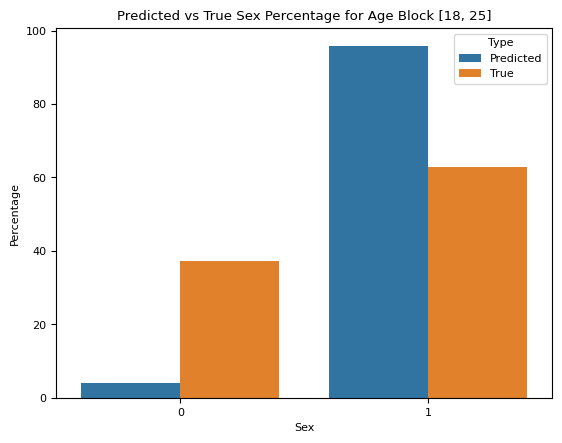

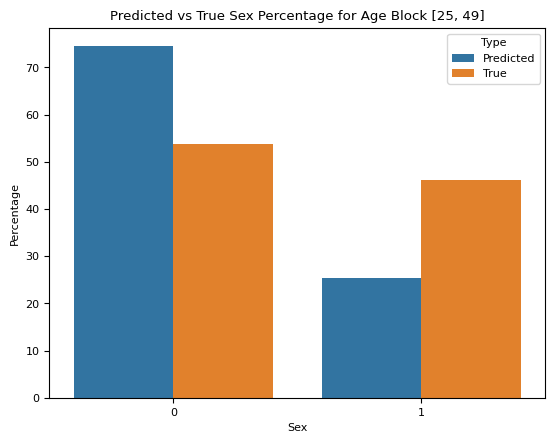

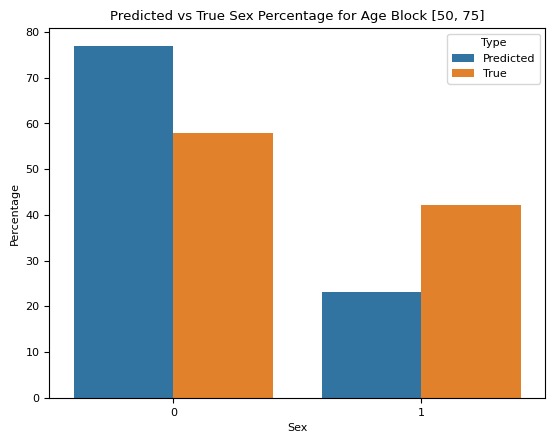

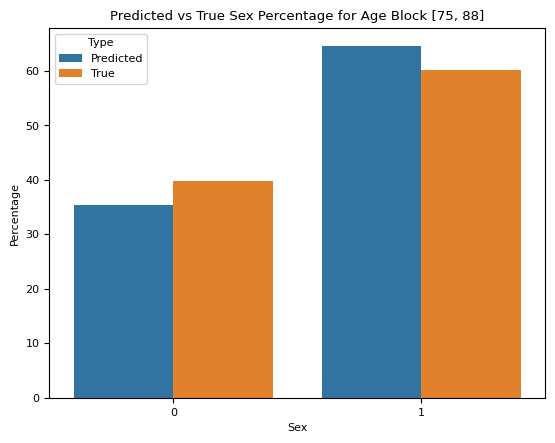

In [42]:
block_list = [[18,25], [25, 49], [50, 75], [75, 88]]

for num, (predicted, true) in enumerate(zip(predicted_sex_block_labels_list_nb, true_sex_labels_list)):
    # Calculate percentages
    predicted_counts = pd.value_counts(predicted, normalize=True) * 100
    true_counts = pd.value_counts(true, normalize=True) * 100
    
    # Create DataFrame for plotting
    df = pd.DataFrame({'Predicted': predicted_counts, 'True': true_counts}).reset_index()
    df = df.melt(id_vars='index', var_name='Type', value_name='Percentage')

    df['Sex'] = df['index']
    
    # Plotting
    sns.barplot(x='Sex', y='Percentage', hue='Type', data=df)
    plt.title(f"Predicted vs True Sex Percentage for Age Block {block_list[num]}")
    plt.ylabel('Percentage')
    plt.xlabel('Sex')
    plt.legend(title='Type')
    plt.show()


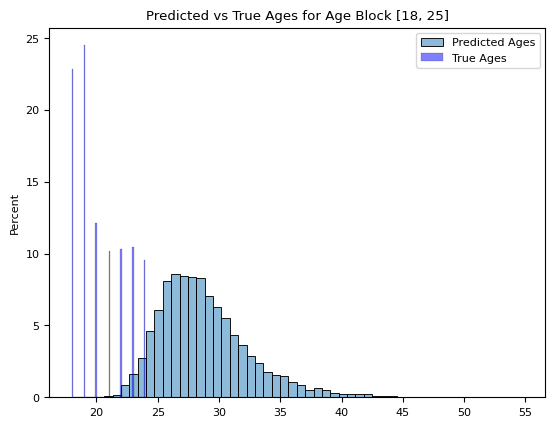

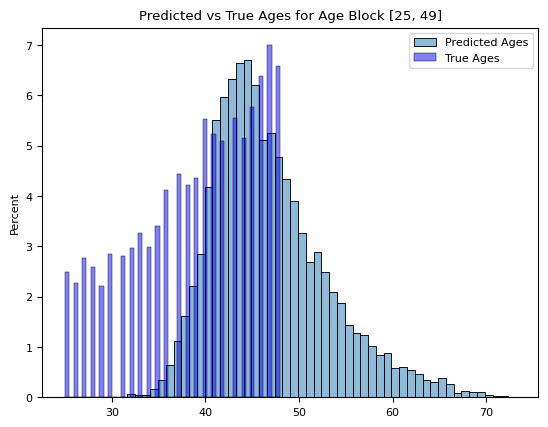

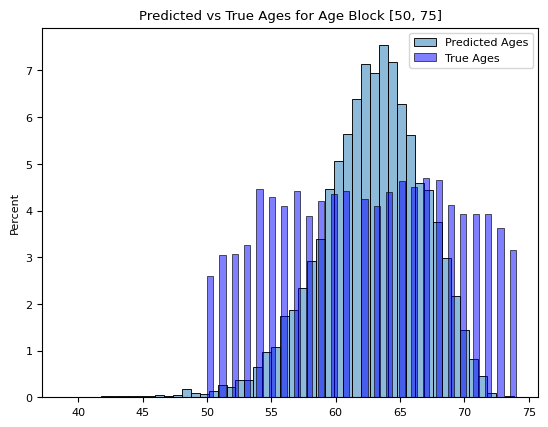

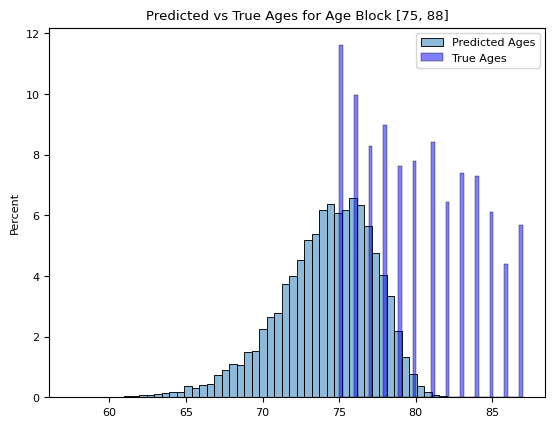

In [39]:
for num, (predicted, true) in enumerate(zip(predicted_age_block_labels_list_nb, true_age_block_labels_list)):
    sns.histplot(predicted, bins=50, color='red', stat = 'percent', alpha=0.5, label='Predicted Ages')
    sns.histplot(true, bins=50, color='blue', stat = 'percent',alpha=0.5, label='True Ages')
    plt.title(f"Predicted vs True Ages for Age Block {block_list[num]}")

    plt.legend()
    plt.show()

In [18]:
for i in true_age_block_labels_list:
    print(len(i))

735
4147
11899
4051


### Analysis
* The Unboosted prediction was most accurate for the 50-75 age range. Likley because of the amount of data that the GANS mopdel had to train on
* The worst performance was on the 18-25 age range. Again, largley due to the amount of data the GANS model could use.
*Interestingly, for both the 25-49 and 75+ age blocks, the model appeared to fall halfway through the correct range of values and had roughly half the values to train on.
    * This shows the direct correlation between data presence and generated data accruracy.
    * Half the data ~ half the range of accuracy
    * There is much nuance to this however but it is something to consider